In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cert-insider-threat/psychometric.csv
/kaggle/input/cert-insider-threat/email.csv


# Imports

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import Dense, GRU
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.metrics import accuracy_score


2024-12-26 06:38:28.441157: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-26 06:38:28.441316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-26 06:38:28.605059: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading our data and exploratory data analysis (EDA)

In [3]:
import pandas as pd

# Load the data
data = pd.read_csv('/kaggle/input/cert-insider-threat/email.csv')

# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'], format='%m/%d/%Y %H:%M:%S')

# Check for missing values
missing_values = data.isnull().sum()

# Basic statistics and info
data_info = data.describe()
data_info = data.info()

# Exploratory Data Analysis
# Volume of emails sent over time
email_volume = data.groupby(data['date'].dt.date).size()

# Frequency of emails by user
user_frequency = data['user'].value_counts()

# Number of attachments analysis
attachment_analysis = data['attachments'].value_counts()

# Display results
print("Missing Values:\n", missing_values)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2629979 entries, 0 to 2629978
Data columns (total 11 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           object        
 1   date         datetime64[ns]
 2   user         object        
 3   pc           object        
 4   to           object        
 5   cc           object        
 6   bcc          object        
 7   from         object        
 8   size         int64         
 9   attachments  int64         
 10  content      object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 220.7+ MB
Missing Values:
 id                   0
date                 0
user                 0
pc                   0
to                   0
cc             1617054
bcc            2212977
from                 0
size                 0
attachments          0
content              0
dtype: int64


In [4]:
print("Data Info:\n", data_info)

Data Info:
 None


In [5]:
print("Email Volume Over Time:\n", email_volume)

Email Volume Over Time:
 date
2010-01-02     350
2010-01-03     390
2010-01-04    7912
2010-01-05    7861
2010-01-06    7924
              ... 
2011-05-12    6797
2011-05-13    6723
2011-05-14     321
2011-05-15     319
2011-05-16    6761
Length: 500, dtype: int64


In [6]:
print("User Frequency:\n", user_frequency)

User Frequency:
 user
MSS0001    12034
KBP0008     9145
HTH0007     9116
HCS0003     9097
KWC0004     8997
           ...  
DAR0885      109
MTT0901       82
JRH0455       51
LPH0572       36
EAH0466       34
Name: count, Length: 1000, dtype: int64


In [7]:
print("Attachment Analysis:\n", attachment_analysis)

Attachment Analysis:
 attachments
0    2066683
1     332335
2     122620
3      46157
4      23450
5      13316
6       8800
7       6515
9       5794
8       4309
Name: count, dtype: int64


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'], format='%m/%d/%Y %H:%M:%S')

# Handle missing values in 'cc' and 'bcc'
data['cc'] = data['cc'].fillna('')
data['bcc'] = data['bcc'].fillna('')

# Feature Engineering
data['num_recipients'] = data['to'].str.count(';') + data['cc'].str.count(';') + data['bcc'].str.count(';') + 1
data['hour'] = data['date'].dt.hour
data['day_of_week'] = data['date'].dt.dayofweek


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


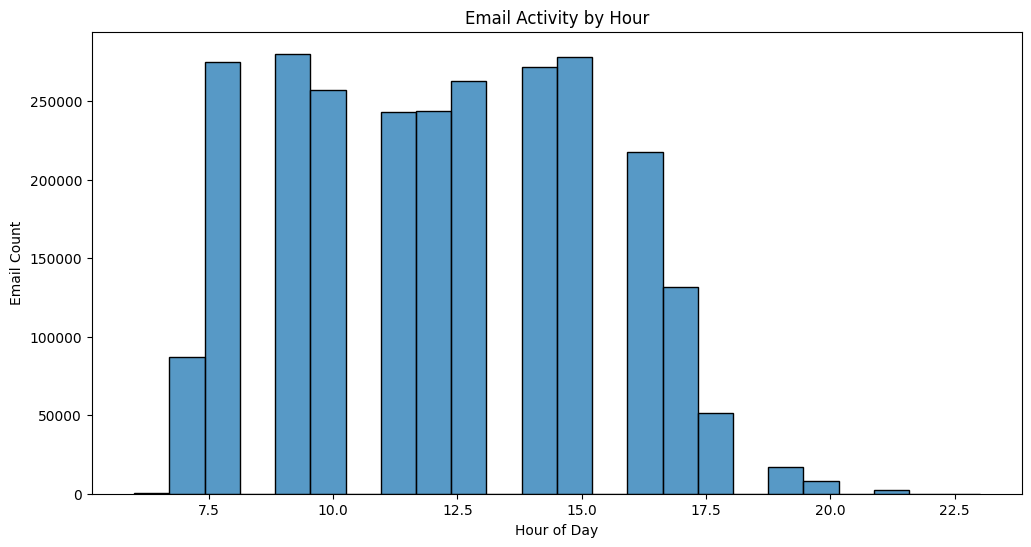

In [9]:
# Time-based Analysis
plt.figure(figsize=(12, 6))
sns.histplot(data['hour'], bins=24, kde=False)
plt.title('Email Activity by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Email Count')
plt.show()

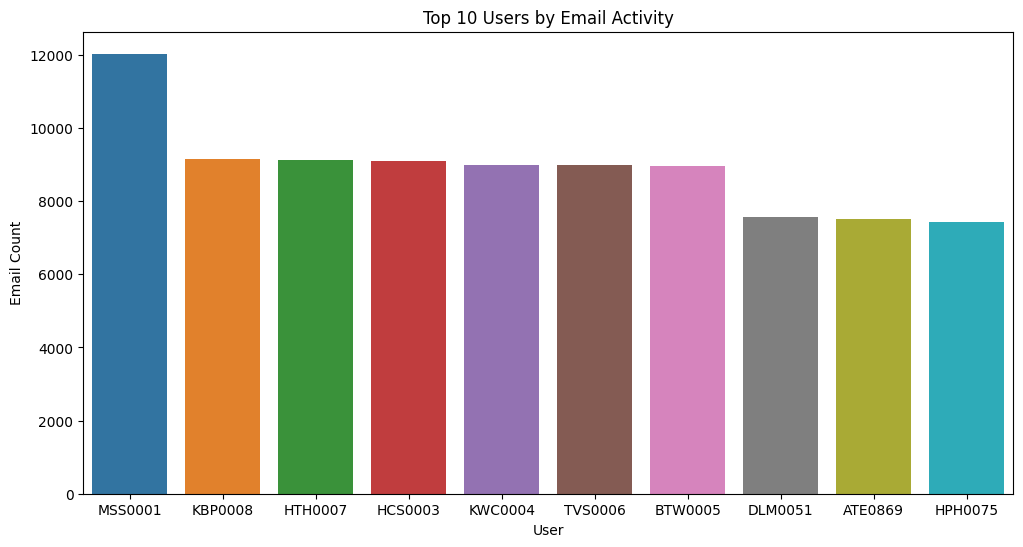

In [10]:
# User-based Analysis
top_users = data['user'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_users.index, y=top_users.values)
plt.title('Top 10 Users by Email Activity')
plt.xlabel('User')
plt.ylabel('Email Count')
plt.show()

In [11]:
# Prepare data for anomaly detection
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

features = ['size', 'attachments', 'num_recipients', 'hour', 'day_of_week']
X = data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the model
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
data['anomaly'] = model.fit_predict(X_scaled)

# Analyze anomalies
anomalies = data[data['anomaly'] == -1]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


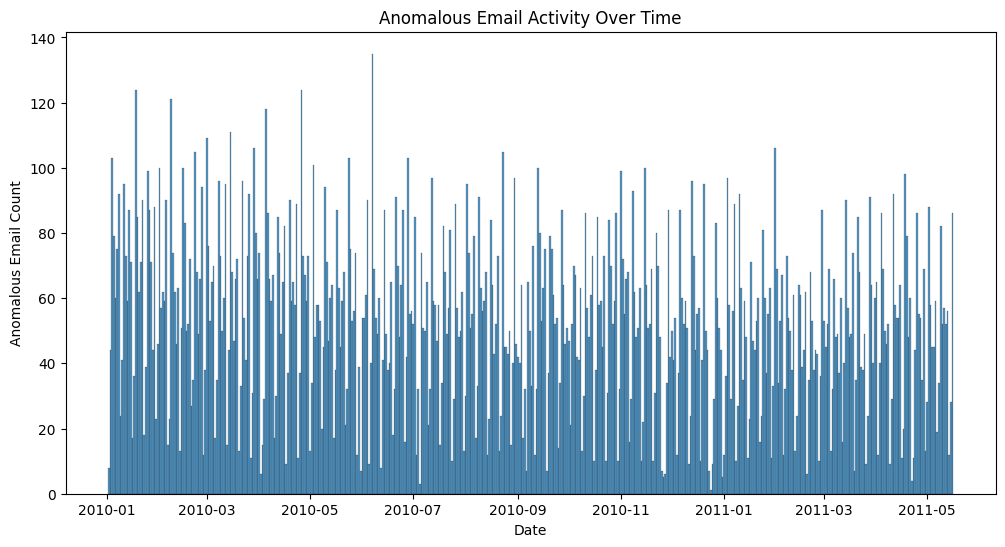

Number of Anomalies Detected: 26300


In [12]:
# Plot anomalies over time
plt.figure(figsize=(12, 6))
sns.histplot(anomalies['date'].dt.date, bins=30, kde=False)
plt.title('Anomalous Email Activity Over Time')
plt.xlabel('Date')
plt.ylabel('Anomalous Email Count')
plt.show()

print(f"Number of Anomalies Detected: {len(anomalies)}")

# Data preprocessing

In [14]:
# Sample 10% of your data
data_sample = data.sample(frac=0.1, random_state=42)

In [15]:
# Continue with your preprocessing
data_sample['date'] = pd.to_datetime(data_sample['date'], format='%m/%d/%Y %H:%M:%S')
data_sample['cc'] = data_sample['cc'].fillna('')
data_sample['bcc'] = data_sample['bcc'].fillna('')

data_sample['num_recipients'] = data_sample['to'].str.count(';') + data_sample['cc'].str.count(';') + data_sample['bcc'].str.count(';') + 1
data_sample['hour'] = data_sample['date'].dt.hour
data_sample['day_of_week'] = data_sample['date'].dt.dayofweek

In [16]:
# Vectorize content using TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
content_tfidf = tfidf.fit_transform(data_sample['content']).toarray()
content_tfidf_df = pd.DataFrame(content_tfidf, columns=tfidf.get_feature_names_out())

In [17]:
# Combine numeric features with TF-IDF features
features = ['size', 'attachments', 'num_recipients', 'hour', 'day_of_week']
X_numeric = data_sample[features]
X = pd.concat([X_numeric.reset_index(drop=True), content_tfidf_df.reset_index(drop=True)], axis=1)


In [18]:
# Standardize numeric features
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)
X_scaled = pd.concat([pd.DataFrame(X_numeric_scaled, columns=features).reset_index(drop=True), content_tfidf_df.reset_index(drop=True)], axis=1)

In [19]:
# Use IsolationForest to detect anomalies and create the 'anomaly' column
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
data_sample['anomaly'] = model.fit_predict(X_scaled)
data_sample['anomaly'] = data_sample['anomaly'].map({1: 0, -1: 1})  # Convert from {1, -1} to {0, 1}

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [20]:
# Split the data
y = data_sample['anomaly']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Random forest

In [21]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     52062
           1       0.00      0.00      0.00       538

    accuracy                           0.99     52600
   macro avg       0.49      0.50      0.50     52600
weighted avg       0.98      0.99      0.98     52600



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
acc = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy using random forest is: {acc*100:.3f} %")

Accuracy using random forest is: 98.977 %


# LSTM

In [23]:
# LSTM
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [24]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(2, activation='softmax'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train_cat, epochs=10, batch_size=64, validation_split=0.2, verbose=2)
y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
print("LSTM Classification Report:")
print(classification_report(y_test, y_pred_lstm))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2630/2630 - 20s - 8ms/step - accuracy: 0.9899 - loss: 0.0637 - val_accuracy: 0.9897 - val_loss: 0.0421
Epoch 2/10
2630/2630 - 15s - 6ms/step - accuracy: 0.9902 - loss: 0.0355 - val_accuracy: 0.9899 - val_loss: 0.0340
Epoch 3/10
2630/2630 - 16s - 6ms/step - accuracy: 0.9908 - loss: 0.0281 - val_accuracy: 0.9905 - val_loss: 0.0290
Epoch 4/10
2630/2630 - 15s - 6ms/step - accuracy: 0.9918 - loss: 0.0230 - val_accuracy: 0.9910 - val_loss: 0.0270
Epoch 5/10
2630/2630 - 16s - 6ms/step - accuracy: 0.9932 - loss: 0.0183 - val_accuracy: 0.9916 - val_loss: 0.0261
Epoch 6/10
2630/2630 - 16s - 6ms/step - accuracy: 0.9942 - loss: 0.0146 - val_accuracy: 0.9908 - val_loss: 0.0272
Epoch 7/10
2630/2630 - 16s - 6ms/step - accuracy: 0.9955 - loss: 0.0119 - val_accuracy: 0.9904 - val_loss: 0.0330
Epoch 8/10
2630/2630 - 16s - 6ms/step - accuracy: 0.9962 - loss: 0.0096 - val_accuracy: 0.9904 - val_loss: 0.0412
Epoch 9/10
2630/2630 - 15s - 6ms/step - accuracy: 0.9970 - loss: 0.0079 - val_accuracy: 

In [25]:
acc = accuracy_score(y_test, y_pred_lstm)
print(f"The Accuracy using LSTM method is : {acc*100:.3f} %")

The Accuracy using LSTM method is : 98.871 %


# GRU

In [26]:
# GRU
X_train_gru = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_gru = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

gru_model = Sequential()
gru_model.add(GRU(50, input_shape=(X_train_gru.shape[1], X_train_gru.shape[2]), return_sequences=True))
gru_model.add(GRU(50))
gru_model.add(Dense(2, activation='softmax'))

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.fit(X_train_gru, y_train_cat, epochs=10, batch_size=64, validation_split=0.2, verbose=2)
y_pred_gru = np.argmax(gru_model.predict(X_test_gru), axis=1)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2630/2630 - 18s - 7ms/step - accuracy: 0.9898 - loss: 0.0553 - val_accuracy: 0.9897 - val_loss: 0.0369
Epoch 2/10
2630/2630 - 14s - 5ms/step - accuracy: 0.9905 - loss: 0.0308 - val_accuracy: 0.9907 - val_loss: 0.0289
Epoch 3/10
2630/2630 - 14s - 5ms/step - accuracy: 0.9915 - loss: 0.0246 - val_accuracy: 0.9917 - val_loss: 0.0247
Epoch 4/10
2630/2630 - 15s - 6ms/step - accuracy: 0.9921 - loss: 0.0214 - val_accuracy: 0.9913 - val_loss: 0.0246
Epoch 5/10
2630/2630 - 14s - 5ms/step - accuracy: 0.9927 - loss: 0.0191 - val_accuracy: 0.9914 - val_loss: 0.0249
Epoch 6/10
2630/2630 - 14s - 6ms/step - accuracy: 0.9937 - loss: 0.0164 - val_accuracy: 0.9913 - val_loss: 0.0241
Epoch 7/10
2630/2630 - 14s - 5ms/step - accuracy: 0.9945 - loss: 0.0141 - val_accuracy: 0.9912 - val_loss: 0.0264
Epoch 8/10
2630/2630 - 14s - 5ms/step - accuracy: 0.9953 - loss: 0.0118 - val_accuracy: 0.9909 - val_loss: 0.0286
Epoch 9/10
2630/2630 - 14s - 5ms/step - accuracy: 0.9959 - loss: 0.0099 - val_accuracy: 

In [27]:
print("GRU Classification Report:")
print(classification_report(y_test, y_pred_gru))

GRU Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     52062
           1       0.55      0.25      0.35       538

    accuracy                           0.99     52600
   macro avg       0.77      0.63      0.67     52600
weighted avg       0.99      0.99      0.99     52600



In [28]:
acc = accuracy_score(y_test, y_pred_gru)
print(f"The Accuracy using GRU method is : {acc*100:.3f} %")

The Accuracy using GRU method is : 99.021 %


# Gradient Boosting 

In [29]:
# Gradient Boosting
gbdt = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbdt.fit(X_train, y_train)
y_pred_gbdt = gbdt.predict(X_test)
print("Gradient Boosting Decision Trees Classification Report:")
print(classification_report(y_test, y_pred_gbdt))

Gradient Boosting Decision Trees Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     52062
           1       0.27      0.03      0.05       538

    accuracy                           0.99     52600
   macro avg       0.63      0.51      0.52     52600
weighted avg       0.98      0.99      0.98     52600



In [30]:
acc = accuracy_score(y_test, y_pred_gbdt)
print(f"The Accuracy using Gradient Boosting is: {acc*100:.3f} %")

The Accuracy using Gradient Boosting is: 98.924 %


# Multi-Layer Perceptron (MLP)

In [31]:
# Multi-Layer Perceptron
mlp = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=100, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
print("Multi-Layer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_mlp))

Multi-Layer Perceptron Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     52062
           1       0.53      0.34      0.42       538

    accuracy                           0.99     52600
   macro avg       0.76      0.67      0.71     52600
weighted avg       0.99      0.99      0.99     52600



In [32]:
acc = accuracy_score(y_test, y_pred_mlp)
print(f"The Accuracy using mlp is : {acc*100:.3f} %")

The Accuracy using mlp is : 99.017 %


# Stacking ensemble

In [33]:
# Stacking Ensemble
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gbdt', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=100, random_state=42))
]

stacking = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(n_estimators=100, random_state=42))
stacking.fit(X_train, y_train)
y_pred_stacking = stacking.predict(X_test)
print("Stacking Ensemble Classification Report:")
print(classification_report(y_test, y_pred_stacking))

Stacking Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     52062
           1       0.58      0.28      0.38       538

    accuracy                           0.99     52600
   macro avg       0.79      0.64      0.69     52600
weighted avg       0.99      0.99      0.99     52600



In [34]:
acc = accuracy_score(y_test, y_pred_mlp)
print(f"The Accuracy using stacking ensemble method is : {acc*100:.3f} %")

The Accuracy using stacking ensemble method is : 99.017 %
